# Programming Assignment 2 by Zach Hatzenbeller

#### Problem 1 Imports

In [1]:
# Part 1 imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Part 2 imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

#### Problem 2 Imports

In [3]:
# Part 1 Imports
from scipy.stats import chi2

## Problem 1 - Feature Ranking Methods (FLDR, Decision Tree Classification)

### Part 1

In [4]:
# Load the data
mnist = pd.read_csv("trainFeatures42k.csv")
X = mnist.values[:,1:]
y = mnist.values[:,0]

In [5]:
# Class to calculate the fischer score to rank features
def fisher_score(X, y):
    # Find unique classes and number of features
    classes = np.unique(y)
    n_features = X.shape[1]
    
    # Overall mean of each feature
    mean_overall = np.mean(X, axis=0)
    
    # Initialize S_B (between-class variance) and S_W (within-class variance)
    S_B = np.zeros(n_features)
    S_W = np.zeros(n_features)
    
    # Calculate S_B and S_W for each feature
    for c in classes:
        X_c = X[y == c]  # Data points for class c
        mean_c = np.mean(X_c, axis=0)  # Mean of each feature for class c
        n_c = X_c.shape[0]  # Number of data points in class c
        
        # Update between-class and within-class variances
        S_B += n_c * (mean_c - mean_overall) ** 2
        S_W += np.sum((X_c - mean_c) ** 2, axis=0)
    
    # Compute Fisher Score: S_B / S_W
    with np.errstate(divide='ignore', invalid='ignore'):
        scores = S_B / S_W
        scores[np.isnan(scores)] = 0  # Set scores where S_W is zero to 0 (avoid division by zero)
    
    return scores

# Compute Fisher scores
scores = fisher_score(X, y)

# Rank features
ranked_features = np.argsort(scores)[::-1]  # Descending order
print("Features Sort by Importance:")
print(ranked_features)


Features Sort by Importance:
[41 40 20  2 42  0 21  4 22  6 44  3 11 51 43 46  7 23 45  1  5 48 27 10
 29 12 52 26 49 30 25 47 24 19 28 34 56 31 53  9 33 50 58 57 35 13  8 18
 39 15 55 32 36 59 14 16 54 38 37 17]


### Part 2

In [6]:
# Part 2A
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=0)
model = clf.fit(X, y)
# cross_val_score(clf, X, y, cv=5)

In [7]:
# Part 2B
def k_fold_cross_validation(X: np.ndarray, y: np.ndarray, k=5):
    fold_size = len(X) // k
    folds_x = {}
    folds_y = {}

    for i in range(k):
        start = i * fold_size
        end = start + fold_size
        folds_x[i] = X[start:end,:]
        folds_y[i] = y[start:end]

    for i in range(k):
        X_test = folds_x[i]
        y_test = folds_y[i]
        X_train = []
        y_train = []

        for j in range(k):
            if j != i:
                X_train.extend(folds_x[j].tolist())
                y_train.extend(folds_y[j].tolist())

        yield np.array(X_train), X_test, np.array(y_train), y_test

fold = 0
for X_train, X_test, y_train, y_test in k_fold_cross_validation(X, y, k=5):
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    print(f"Fold {fold} Accuracy: {accuracy_score(y_test, y_preds)}")
    fold += 1

Fold 0 Accuracy: 0.853434932730087
Fold 1 Accuracy: 0.8511727586617455
Fold 2 Accuracy: 0.850696511489463
Fold 3 Accuracy: 0.8424812477675914
Fold 4 Accuracy: 0.8508155732825337


In [8]:
# Part 2C
decision_tree_features = np.argsort(model.feature_importances_)[::-1]
print("Features Sort by Importance:")
print(decision_tree_features)

Features Sort by Importance:
[20 42 40 41  0  2 43  3 46  1 48 44 22 49 51 11  4 21  6  9 29 50 47 23
  7 57 31 52 25 45 56 28 54 12  5 24 30 58 53  8 27 10 35 34 16 19 13 33
 39 55 26 32 17 14 37 38 15 18 36 59]


In [9]:
# Part 2D
# UNIT TESTING STILL NEEDS TO BE IMPLEMENTED!!

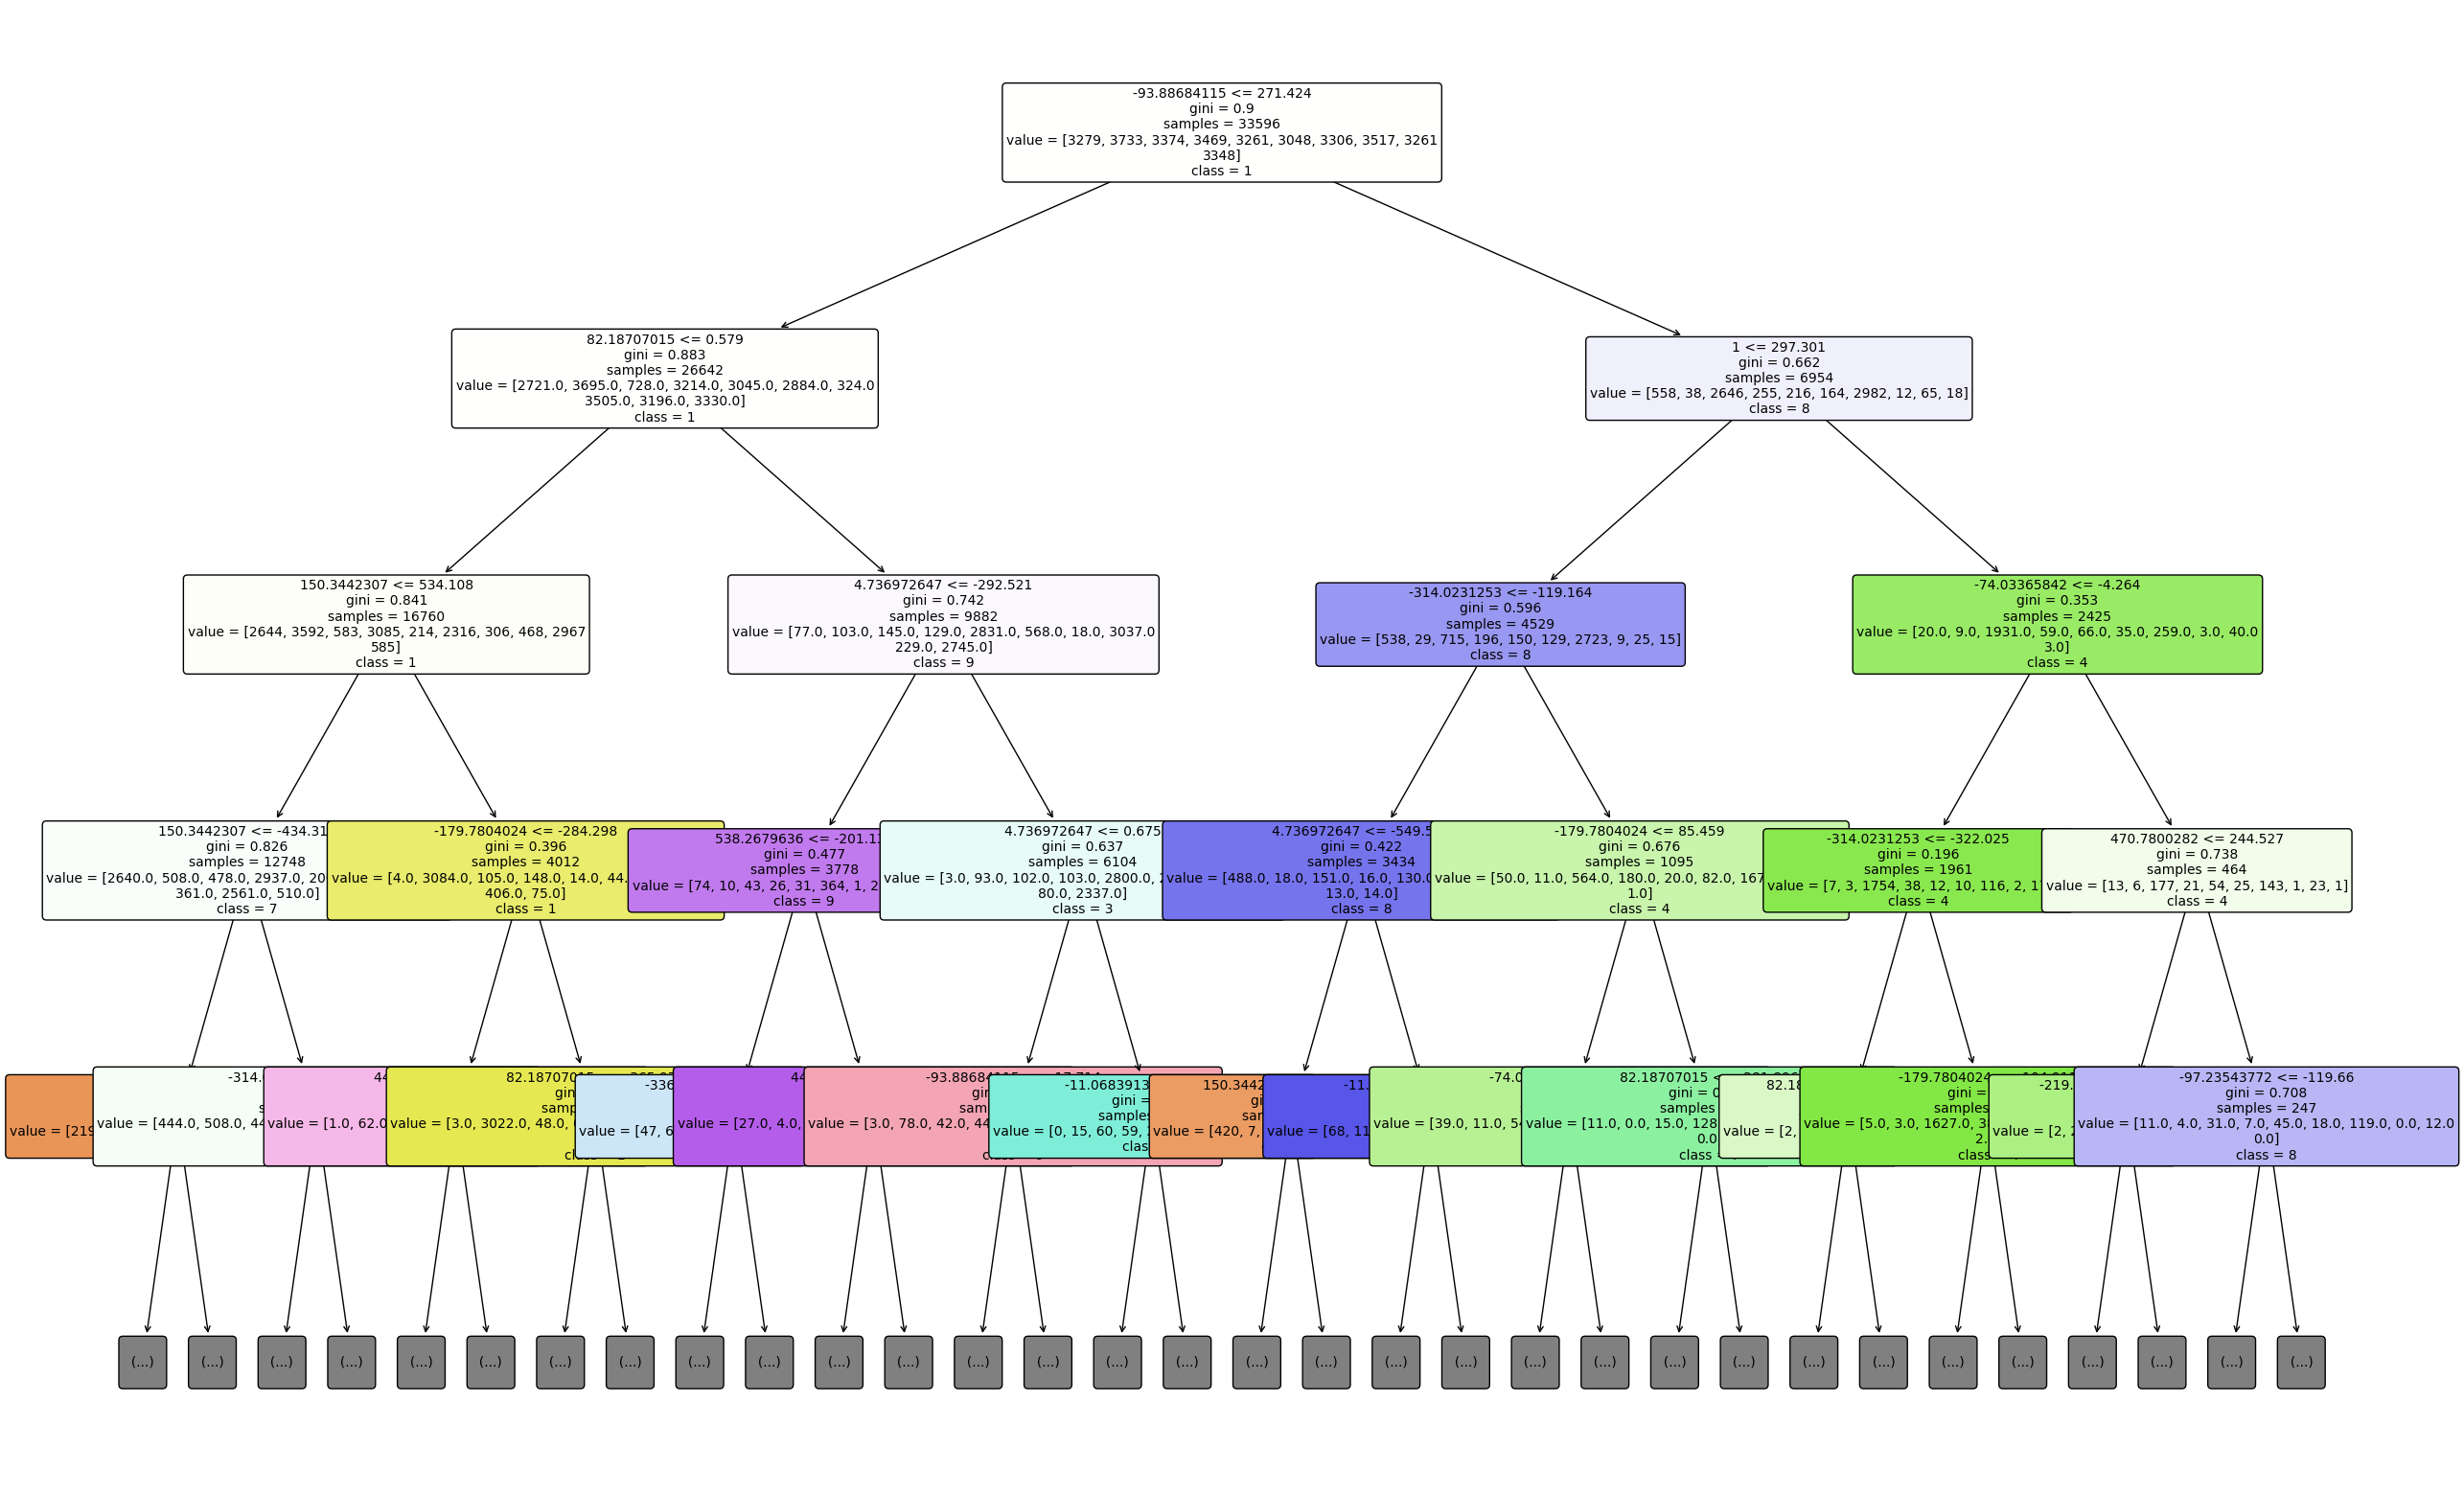

In [10]:
# Part 2E
target_labels = [str(i) for i in mnist.iloc[:,0].unique()]
plt.figure(figsize=(30,20))
tree.plot_tree(
    clf, 
    max_depth=4,
    filled=True,
    feature_names=mnist.columns,
    class_names=target_labels,
    rounded=True,
    fontsize=10
)
plt.show()

#### How `predict` Works

1. **Input Processing**:
   - The `predict` method takes an array of input features (test data). Each input instance (or sample) in the test data is independently passed down the tree.

2. **Traversing the Tree**:
   - Starting at the root node, the decision tree evaluates each input instance against the decision criteria stored in the nodes (typically, these are comparisons of feature values to thresholds).
   - Depending on the outcome of the evaluation, the decision path forks left or right, moving to the subsequent child node. This process repeats recursively until a leaf node is reached.

3. **Output Decision**:
   - Each leaf node in the decision tree contains the predicted class label (in classification tasks) or the predicted value (in regression tasks). This label or value is determined during the tree’s training phase, where the most common class or the average/mode of the target values in the training samples ending up in that leaf is stored.
   - Once a leaf node is reached, the stored prediction is output for the input instance.

#### Runtime Complexity Analysis

The runtime complexity of the `predict` method for decision trees depends primarily on two factors: the depth of the tree and the number of input features. The key points to consider are:

1. **Depth of the Tree (D)**:
   - The most crucial factor in determining the complexity. In the worst case, each sample's prediction requires traversing from the root to a leaf, which takes a number of steps equal to the depth of the tree.
   - Typically, the depth of a well-balanced binary decision tree is \(O(\log n)\) for `n` training samples, but can be as poor as \(O(n)\) in the worst case (e.g., in extremely unbalanced cases where the tree becomes a linked list).

2. **Number of Features (F)**:
   - At each node, a decision involves comparing a value from the input vector to a threshold, generally involving just one feature. However, the need to access specific positions in the input feature vector does introduce a dependency on the number of features, especially in terms of constant-time operations performed at each node.

3. **Number of Samples (S)**:
   - The runtime for predicting labels for `S` samples would generally be \(O(S \times D)\). In practice, for a fixed tree, as the number of samples increases, the total time linearly increases with the number of samples.


In [11]:
# Part 2F

**Decision Tree Feature Importances**:
- Measures how well a feature splits data based on information gain.
- Highly specific to the tree's structure; varies with data or model changes.
- Best for understanding feature effectiveness directly within tree-based models.

**Feature Ranking with Linear Discriminant Ratios (FLDR)**:
- Ranks features based on their ability to linearly discriminate between classes using statistical ratios.
- More stable across different datasets; assumes linear relationships and Gaussian distribution.
- Useful for identifying features that are statistically significant across models, especially linear ones.

**Comparison**:
- Decision tree importances are model-specific and reflect the tree's decision-making process, ideal for tree-based models.
- FLDR provides a broader, model-independent view, suitable for assessing general feature discriminability, particularly for linear models.

Both methods offer insights into feature importance but from different perspectives: one is model-specific and the other more general and statistically grounded.

##

## Problem 2 - Machine Learning

### Part 1

In [12]:
# Load the data
mnist = pd.read_csv("trainFeatures42k.csv")
X = mnist.values[:,1:]
y = mnist.values[:,0]

In [13]:
class preprocessing:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n_comps = None
        self.distance = {}
        self.removal_idx = []
    
    def cov_matrix(self, data):
        row, col = data.shape
        cov_mat = np.zeros([col, col])

        for i in range(col):
            i_mean = np.mean(data[:,i])
            for j in range(col):
                j_mean = np.mean(data[:,j])
                cov_mat[i,j] = np.sum((data[:,i] - i_mean) * (data[:,j] - j_mean)) / (row - 1)

        return cov_mat

    def standard_scaler(self):
        return (self.X - np.mean(self.X, axis=0)) / np.std(self.X, axis=0) 

    def pca(self, n_components):
        self.n_comps = n_components
        # Standardize and Compute the covariance matrix
        # X_scaled = self.standard_scaler()
        X_scaled = self.X.copy()
        covariance_matrix = self.cov_matrix(X_scaled)

        # Compute eigenvalues and eigenvectors and sort
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        # Project data to lower dimensions
        eigenvectors_subset = sorted_eigenvectors[:, :n_components]
        projected_data = np.dot(X_scaled, eigenvectors_subset)

        # Calculate change in variance
        # Calculate total variance before projection
        total_variance_before = np.sum(np.var(X_scaled, axis=0, ddof=1))
        
        # Calculate total variance after projection (sum of selected eigenvalues)
        total_variance_after = np.sum(np.var(projected_data, axis=0, ddof=1))
        
        # Calculate change in variance
        change_in_variance = total_variance_before - total_variance_after
        variance_retained_ratio = total_variance_after / total_variance_before

        return projected_data, variance_retained_ratio

    def mahalanobis(self, y, data_mean, cov_inv):
        diff = y - data_mean
        left = np.dot(diff, cov_inv)
        mahalanobis_dist = np.sqrt(np.dot(left, diff.T))
        return mahalanobis_dist

    def outlier_removal_idx(self, distances, class_arr, training_arr, alpha=0.05):
        degrees_of_freedom = class_arr.shape[1]
        threshold = chi2.ppf(1 - alpha, degrees_of_freedom)
        outlier_dist = distances > threshold
        outlier_vals = class_arr[outlier_dist]
        if outlier_vals.shape[0] != 0:
            outlier_idx = []
            for x in outlier_vals:
                outlier_idx.append(np.where((training_arr == x).all(axis=1))[0][0].tolist())
            return outlier_idx
        else:
            return "No Outliers Exist in Class"
    
    def fischer_score_helper(self):
        if self.n_comps is not None:
            x_data, _ = data_pre.pca(self.n_comps)
        else:
            x_data = self.X.copy()
        scores = fisher_score(x_data, self.y)
        return np.argsort(scores)[::-1]

    def clean_data(self, n_comps, feature_select=5):
        cleaned_data, _ = data_pre.pca(n_comps)
        scores = self.fischer_score_helper()
        cleaned_data = cleaned_data[:, scores[:feature_select]]
        classes = np.unique(self.y)
        for class_ in classes:

            class_distance = []
            arr = cleaned_data[np.where(y==class_)]
            mean_ = arr.mean(axis=0)
            covariance = self.cov_matrix(arr)
            cov_inv = np.linalg.inv(covariance)

            for idx in range(arr.shape[0]):
                class_distance.append(self.mahalanobis(arr[idx,:], mean_, cov_inv))

            self.distance[class_] = class_distance

        for key, dist in self.distance.items():
            class_arr = cleaned_data[np.where(y==key)]
            index = self.outlier_removal_idx(dist, class_arr, self.X, alpha=0.05)
            self.removal_idx.extend(index)

# Scaling data generates worse score for variance ratio
# I chose not to scale the data as maintaining variance is important
data_pre = preprocessing(X, y)
data_pre.clean_data(31)

0.9047949565296892

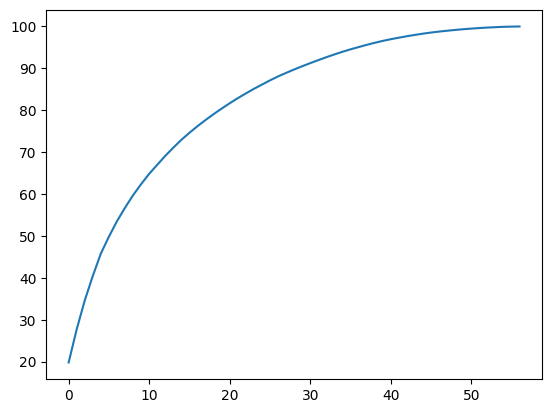

In [15]:
variance = []
for i in range(2,59):
    data_pre = preprocessing(X, y)
    _, variance_ratio = data_pre.pca(i)
    variance.append(variance_ratio)
plt.plot(np.arange(0,len(variance)), np.array(variance)*100)

In [19]:
# Part 1B: Feature Selection

# Using the ranked features from Problem 1 with the Fischer Score
# I select the top 10 features to actually continue with
new_X = X[:, ranked_features[:5]]

In [20]:
# Part 1B: Outlier Removal

def cov_matrix(data):
    row, col = data.shape
    cov_mat = np.zeros([col, col])

    for i in range(col):
        i_mean = np.mean(data[:,i])
        for j in range(col):
            j_mean = np.mean(data[:,j])
            cov_mat[i,j] = np.sum((data[:,i] - i_mean) * (data[:,j] - j_mean)) / (row - 1)

    return cov_mat

def mahalanobis(y, data_mean, cov_inv):
    diff = y - data_mean
    left = np.dot(diff, cov_inv)
    mahalanobis_dist = np.sqrt(np.dot(left, diff.T))
    return mahalanobis_dist

def outlier_removal_idx(distances, class_arr, training_arr, alpha=0.05):
    degrees_of_freedom = class_arr.shape[1]
    threshold = chi2.ppf(1 - alpha, degrees_of_freedom)
    outlier_dist = distances > threshold
    outlier_vals = class_arr[outlier_dist]
    if outlier_vals.shape[0] != 0:
        outlier_idx = []
        for x in outlier_vals:
            outlier_idx.append(np.where((training_arr == x).all(axis=1))[0][0].tolist())
        return outlier_idx
    else:
        return "No Outliers Exist in Class"


mnist_distance = {}
mnist_classes = np.unique(y)
for class_ in mnist_classes:
    class_distance = []

    arr = new_X[np.where(y==class_)]
    mean_ = arr.mean(axis=0)
    covariance = cov_matrix(arr)
    cov_inv = np.linalg.inv(covariance)

    for idx in range(arr.shape[0]):
        class_distance.append(mahalanobis(arr[idx,:], mean_, cov_inv))

    mnist_distance[class_] = class_distance

print("Distances for MNIST")
for key, dist in mnist_distance.items():
    class_arr = new_X[np.where(y==key)]
    index = outlier_removal_idx(dist, class_arr, new_X, alpha=0.05)
    print(index)

Distances for MNIST
No Outliers Exist in Class
[621, 4788, 4949, 11810, 12689, 23035, 23038, 27336, 28668, 31619]
No Outliers Exist in Class
No Outliers Exist in Class
No Outliers Exist in Class
No Outliers Exist in Class
No Outliers Exist in Class
No Outliers Exist in Class
No Outliers Exist in Class
No Outliers Exist in Class


In [ ]:
arr.shape[0]

4132